In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Set, Optional
from collections import deque
import warnings
warnings.filterwarnings('ignore')

@dataclass
class State:
    robot_pos: Tuple[int, int]
    holding: Optional[str] = None
    visited: Set[Tuple[int, int]] = field(default_factory=set)
    objects_collected: Set[str] = field(default_factory=set)
    def __hash__(self):
        return hash((self.robot_pos, self.holding))

class SymbolicPlanner:
    def __init__(self, grid_size: int = 8):
        self.grid_size = grid_size
        self.actions = ['up', 'down', 'left', 'right', 'pickup', 'drop']
    def get_successors(self, state: State, obstacles: Set[Tuple[int, int]], objects: Dict[str, Tuple[int, int]]) -> List[Tuple[str, State]]:
        successors = []
        x, y = state.robot_pos
        moves = {'up': (x, y-1), 'down': (x, y+1), 'left': (x-1, y), 'right': (x+1, y)}
        for action, new_pos in moves.items():
            nx, ny = new_pos
            if (0 <= nx < self.grid_size and 0 <= ny < self.grid_size and new_pos not in obstacles):
                new_state = State(new_pos, state.holding, state.visited | {new_pos}, state.objects_collected.copy())
                successors.append((action, new_state))
        if state.holding is None:
            for obj_name, obj_pos in objects.items():
                if state.robot_pos == obj_pos and obj_name not in state.objects_collected:
                    new_state = State(state.robot_pos, obj_name, state.visited.copy(), state.objects_collected.copy())
                    successors.append(('pickup', new_state))
        if state.holding is not None:
            new_state = State(state.robot_pos, None, state.visited.copy(), state.objects_collected | {state.holding})
            successors.append(('drop', new_state))
        return successors
    def heuristic(self, state: State, goal: Tuple[int, int]) -> float:
        return abs(state.robot_pos[0] - goal[0]) + abs(state.robot_pos[1] - goal[1])
    def a_star_plan(self, start_state: State, goal: Tuple[int, int], obstacles: Set[Tuple[int, int]], objects: Dict[str, Tuple[int, int]]) -> List[str]:
        counter = 0
        frontier = [(self.heuristic(start_state, goal), counter, 0, start_state, [])]
        visited = set()
        while frontier:
            frontier.sort()
            _, _, cost, state, plan = frontier.pop(0)
            counter += 1
            if state.robot_pos == goal and len(state.objects_collected) >= len(objects):
                return plan
            state_key = (state.robot_pos, state.holding)
            if state_key in visited:
                continue
            visited.add(state_key)
            for action, next_state in self.get_successors(state, obstacles, objects):
                new_cost = cost + 1
                new_plan = plan + [action]
                priority = new_cost + self.heuristic(next_state, goal)
                frontier.append((priority, counter, new_cost, next_state, new_plan))
                counter += 1
        return []

In [ ]:
class NeuralPerception:
    def __init__(self, grid_size: int = 8):
        self.grid_size = grid_size
        self.W1 = np.random.randn(grid_size * grid_size, 64) * 0.1
        self.b1 = np.zeros(64)
        self.W2 = np.random.randn(64, 32) * 0.1
        self.b2 = np.zeros(32)
        self.W3 = np.random.randn(32, grid_size * grid_size) * 0.1
        self.b3 = np.zeros(grid_size * grid_size)
    def relu(self, x):
        return np.maximum(0, x)
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    def perceive(self, noisy_grid: np.ndarray) -> np.ndarray:
        x = noisy_grid.flatten()
        h1 = self.relu(x @ self.W1 + self.b1)
        h2 = self.relu(h1 @ self.W2 + self.b2)
        out = self.sigmoid(h2 @ self.W3 + self.b3)
        return out.reshape(self.grid_size, self.grid_size)

class NeuralPolicy:
    def __init__(self, state_dim: int = 4, action_dim: int = 4):
        self.W = np.random.randn(state_dim, action_dim) * 0.1
        self.b = np.zeros(action_dim)
        self.action_map = ['up', 'down', 'left', 'right']
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum()
    def get_action_probs(self, state_features: np.ndarray) -> np.ndarray:
        logits = state_features @ self.W + self.b
        return self.softmax(logits)
    def select_action(self, state_features: np.ndarray, symbolic_action: str) -> str:
        probs = self.get_action_probs(state_features)
        if symbolic_action in self.action_map:
            sym_idx = self.action_map.index(symbolic_action)
            probs[sym_idx] += 0.7
            probs = probs / probs.sum()
        return np.random.choice(self.action_map, p=probs)

In [ ]:
class NeuroSymbolicAgent:
    def __init__(self, grid_size: int = 8):
        self.grid_size = grid_size
        self.planner = SymbolicPlanner(grid_size)
        self.perception = NeuralPerception(grid_size)
        self.policy = NeuralPolicy()
        self.obstacles = {(3, 3), (3, 4), (4, 3), (5, 5), (6, 2)}
        self.objects = {'key': (2, 6), 'gem': (6, 6)}
        self.goal = (7, 7)
    def create_noisy_observation(self, true_grid: np.ndarray) -> np.ndarray:
        noise = np.random.randn(*true_grid.shape) * 0.2
        return np.clip(true_grid + noise, 0, 1)
    def extract_state_features(self, pos: Tuple[int, int], goal: Tuple[int, int]) -> np.ndarray:
        return np.array([pos[0]/self.grid_size, pos[1]/self.grid_size, goal[0]/self.grid_size, goal[1]/self.grid_size])
    def execute_mission(self, verbose: bool = True) -> Tuple[List, List]:
        start_state = State(robot_pos=(0, 0), visited={(0, 0)})
        symbolic_plan = self.planner.a_star_plan(start_state, self.goal, self.obstacles, self.objects)
        if verbose:
            print(f"🧠 Symbolic Plan Generated: {len(symbolic_plan)} steps")
            print(f"   Plan: {symbolic_plan[:10]}{'...' if len(symbolic_plan) > 10 else ''}\n")
        true_grid = np.zeros((self.grid_size, self.grid_size))
        for obs in self.obstacles:
            true_grid[obs[1], obs[0]] = 1.0
        noisy_obs = self.create_noisy_observation(true_grid)
        perceived_grid = self.perception.perceive(noisy_obs)
        if verbose:
            print(f"👁️  Neural Perception: Denoised obstacle map")
            print(f"   Perception accuracy: {np.mean((perceived_grid > 0.5) == true_grid):.2%}\n")
        trajectory = [(0, 0)]
        current_pos = (0, 0)
        actions_taken = []
        for i, sym_action in enumerate(symbolic_plan[:30]):
            features = self.extract_state_features(current_pos, self.goal)
            refined_action = self.policy.select_action(features, sym_action) if sym_action in ['up','down','left','right'] else sym_action
            actions_taken.append(refined_action)
            if refined_action == 'up': current_pos = (current_pos[0], max(0, current_pos[1]-1))
            elif refined_action == 'down': current_pos = (current_pos[0], min(self.grid_size-1, current_pos[1]+1))
            elif refined_action == 'left': current_pos = (max(0, current_pos[0]-1), current_pos[1])
            elif refined_action == 'right': current_pos = (min(self.grid_size-1, current_pos[0]+1), current_pos[1])
            if current_pos not in self.obstacles:
                trajectory.append(current_pos)
        return trajectory, actions_taken

In [ ]:
def visualize_execution(agent: NeuroSymbolicAgent, trajectory: List, title: str = "Neuro-Symbolic Agent Execution"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ax = axes[0]
    grid = np.zeros((agent.grid_size, agent.grid_size, 3))
    for obs in agent.obstacles:
        grid[obs[1], obs[0]] = [0.3, 0.3, 0.3]
    for obj_pos in agent.objects.values():
        grid[obj_pos[1], obj_pos[0]] = [1.0, 0.8, 0.0]
    grid[agent.goal[1], agent.goal[0]] = [0.0, 1.0, 0.0]
    for i, pos in enumerate(trajectory):
        intensity = 0.3 + 0.7 * (i / len(trajectory))
        grid[pos[1], pos[0]] = [intensity, 0.0, 1.0]
    if trajectory:
        grid[trajectory[0][1], trajectory[0][0]] = [1.0, 0.0, 0.0]
    ax.imshow(grid)
    ax.set_title("Agent Trajectory in Environment", fontsize=14, fontweight='bold')
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True, alpha=0.3)
    ax = axes[1]
    ax.axis('off')
    ax.text(0.5, 0.95, "Neuro-Symbolic Architecture", ha='center', fontsize=16, fontweight='bold', transform=ax.transAxes)
    layers = [("SYMBOLIC LAYER", 0.75, "Planning • State Logic • Rules"), ("↕ INTEGRATION", 0.60, "Feature Extraction • Action Blending"), ("NEURAL LAYER", 0.45, "Perception • Policy Learning"), ("↕ EXECUTION", 0.30, "Action Refinement • Feedback"), ("ENVIRONMENT", 0.15, "State Transitions • Observations")]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    for i, (name, y, desc) in enumerate(layers):
        ax.add_patch(plt.Rectangle((0.1, y-0.05), 0.8, 0.08, facecolor=colors[i], alpha=0.7, transform=ax.transAxes))
        ax.text(0.5, y, f"{name}\n{desc}", ha='center', va='center', fontsize=10, fontweight='bold', transform=ax.transAxes)
    plt.tight_layout()
    plt.savefig('neurosymbolic_agent.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✅ Execution complete! Trajectory length: {len(trajectory)} steps")

NEURO-SYMBOLIC HYBRID AGENT TUTORIAL
Combining Classical AI Planning with Modern Neural Networks

🧠 Symbolic Plan Generated: 0 steps
   Plan: []

👁️  Neural Perception: Denoised obstacle map
   Perception accuracy: 50.00%



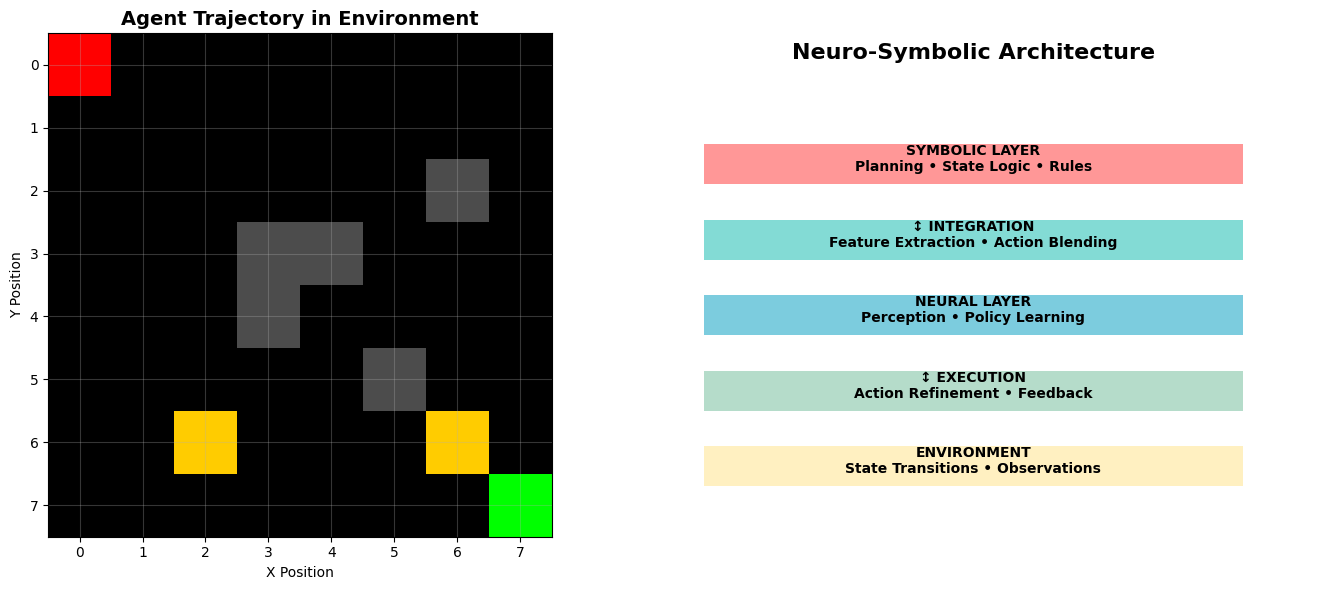


✅ Execution complete! Trajectory length: 1 steps

KEY INSIGHTS:
✦ Symbolic Layer: Provides interpretable, verifiable plans
✦ Neural Layer: Handles noisy perception & adapts to uncertainty
✦ Integration: Combines strengths of both paradigms
✦ Benefits: Explainability + Flexibility + Robustness


In [3]:
if __name__ == "__main__":
    print("=" * 70)
    print("NEURO-SYMBOLIC HYBRID AGENT TUTORIAL")
    print("Combining Classical AI Planning with Modern Neural Networks")
    print("=" * 70)
    print()
    agent = NeuroSymbolicAgent(grid_size=8)
    trajectory, actions = agent.execute_mission(verbose=True)
    visualize_execution(agent, trajectory)
    print("\n" + "=" * 70)
    print("KEY INSIGHTS:")
    print("=" * 70)
    print("✦ Symbolic Layer: Provides interpretable, verifiable plans")
    print("✦ Neural Layer: Handles noisy perception & adapts to uncertainty")
    print("✦ Integration: Combines strengths of both paradigms")
    print("✦ Benefits: Explainability + Flexibility + Robustness")
    print("=" * 70)